# Fine-Tuning

# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
)
from sentence_transformers.losses import CoSENTLoss, MatryoshkaLoss
from datasets import Dataset
from peft import LoraConfig, TaskType
import xgboost as xgb
import torch

2026-02-18 13:16:46.591060: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-18 13:16:47.133075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dkusmenko/.local/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving

In [2]:
import os
# This enables memory fragmentation handling specifically for AMD HIP
os.environ["PYTORCH_HIP_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import torch
def print_gpu_utilization():
    if not torch.cuda.is_available():
        print("No GPU detected.")
        return

    # On AMD ROCm, 'cuda' functions query the HIP backend
    reserved = torch.cuda.memory_reserved()
    allocated = torch.cuda.memory_allocated()
    total_memory = torch.cuda.get_device_properties(0).total_memory
    
    print(f"Total GPU Mem: {total_memory / 1024**3:.2f} GB")
    print(f"Reserved (Cached): {reserved / 1024**3:.2f} GB")
    print(f"Allocated (Active): {allocated / 1024**3:.2f} GB")
    print(f"Free (Approx): {(total_memory - reserved) / 1024**3:.2f} GB")
    print("-" * 30)

# Run it
print_gpu_utilization()

Total GPU Mem: 15.82 GB
Reserved (Cached): 0.00 GB
Allocated (Active): 0.00 GB
Free (Approx): 15.82 GB
------------------------------


/home/dkusmenko/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:736: UserWarning: Can't initialize amdsmi - Error code: 34
  warnings.warn(f"Can't initialize amdsmi - Error code: {e.err_code}")


# Data Import, Clean, and Sample

In [4]:
# ==========================================
# 1. DATA LOADING & PREPROCESSING (STRATIFIED)
# ==========================================
print("Loading freMTPL2freq dataset...")
dataset = fetch_openml(data_id=41214, as_frame=True)
full_df = dataset.frame

# Clean basic types first
full_df['ClaimNb'] = pd.to_numeric(full_df['ClaimNb'])
full_df['Exposure'] = pd.to_numeric(full_df['Exposure'])
full_df['Exposure'] = full_df['Exposure'].clip(upper=1.0)
full_df['Frequency'] = full_df['ClaimNb'] / full_df['Exposure']

# --- CRITICAL STEP: Create Stratification Column ---
# We stratify on whether a claim occurred (Binary) rather than the raw count.
# Stratifying on raw count (0, 1, 2, 3...) often fails because '3' claims is too rare to split.
full_df['has_claim'] = full_df['ClaimNb'] > 0

brand_mapping = {'B1': 'Renault, Nissan, or Citroen', 'B2': 'Renault, Nissan, or Citroen',
                 'B3': 'Volkswagen, Audi, Skoda, or Seat', 'B4': 'Opel, General Motors, or Ford',
                 'B5': 'Opel, General Motors, or Ford','B6': 'Fiat', 'B10':'Mercedes, Chrysler, or BMW',
                 'B11':'Mercedes, Chrysler, or BMW', 'B12': 'Japanese (except Nissan) or Korean', 'B13': 'Other','B14': 'Other' }

region_mapping = {
    "R11": "Île-de-France",
    "R21": "Champagne-Ardenne",
    "R22": "Picardie",
    "R23": "Haute-Normandie",
    "R24": "Centre",
    "R25": "Basse-Normandie",
    "R26": "Bourgogne",
    "R31": "Nord–Pas-de-Calais",
    "R41": "Lorraine",
    "R42": "Alsace",
    "R43": "Franche–Comté",
    "R52": "Pays de la Loire",
    "R53": "Bretagne",
    "R54": "Poitou–Charentes",
    "R72": "Aquitaine",
    "R73": "Midi–Pyrénées",
    "R74": "Limousin",
    "R82": "Rhône–Alpes",
    "R83": "Auvergne",
    "R91": "Languedoc–Roussillon",
    "R93": "Provence–Alpes–Côte d’Azur",
    "R94": "Corse"
}

area_mapping = {
    "A": "rural area",
    "B": "semi-rural area",
    "C": "suburban-fringe area",
    "D": "suburban area",
    "E": "urban area",
    "F": "urban center"
}

gas_mapping = {
    "'Diesel'": "Diesel",
    "'Regular'": "Regular"

}

full_df["VehBrand"] = full_df["VehBrand"].map(brand_mapping)
full_df["Region"] = full_df["Region"].map(region_mapping)
full_df["Area"] = full_df["Area"].map(area_mapping)
full_df["VehGas"] = full_df["VehGas"].map(gas_mapping)

# --- DOWNSAMPLE 50k STRATIFIED ---
# We use train_test_split to 'pick' 50,000 rows while keeping the Claim Ratio intact.
# The 'test_size' is ignored; we just want the 'train' portion to be exactly 50k.
subset_df, _ = train_test_split(
    full_df, 
    train_size=100000, 
    stratify=full_df['has_claim'], # <--- Guarantees representative risk profile
    random_state=42
)

print(f"Stratified Subset Size: {len(subset_df)}")
print(f"Claim Rate in Subset: {subset_df['has_claim'].mean():.4f}")
print(f"Claim Rate in Full Data: {full_df['has_claim'].mean():.4f} (Should match)")

# --- 80/20 TRAIN/TEST SPLIT ---
# Now split your 50k subset into Train/Test for modeling
train_df, test_df = train_test_split(
    subset_df, 
    test_size=0.20,
    random_state=42, 
    stratify=subset_df['has_claim'] # Stratify AGAIN to keep test set fair
)

print(f"Final Train: {len(train_df)} | Final Test: {len(test_df)}")

Loading freMTPL2freq dataset...
Stratified Subset Size: 100000
Claim Rate in Subset: 0.0502
Claim Rate in Full Data: 0.0502 (Should match)
Final Train: 80000 | Final Test: 20000


In [5]:
train_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency,has_claim
407825,3102671.0,0,0.77,suburban-fringe area,5,2,47,50,"Opel, General Motors, or Ford",Regular,198,Île-de-France,0.0,False
13464,32336.0,0,0.34,urban area,5,12,23,90,"Renault, Nissan, or Citroen",Regular,2951,Lorraine,0.0,False
465592,3210480.0,0,1.00,rural area,10,11,68,50,"Renault, Nissan, or Citroen",Regular,15,Provence–Alpes–Côte d’Azur,0.0,False
475594,3240884.0,0,0.16,urban area,4,2,29,72,"Volkswagen, Audi, Skoda, or Seat",Diesel,5410,Île-de-France,0.0,False
454705,3185379.0,0,1.00,semi-rural area,6,14,47,50,"Renault, Nissan, or Citroen",Regular,63,Centre,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618889,5059808.0,0,0.57,suburban area,7,1,73,50,Japanese (except Nissan) or Korean,Diesel,533,Provence–Alpes–Côte d’Azur,0.0,False
200926,2003525.0,0,0.36,rural area,5,2,45,50,Japanese (except Nissan) or Korean,Regular,4,Corse,0.0,False
60108,129687.0,0,1.00,semi-rural area,7,16,47,50,"Renault, Nissan, or Citroen",Regular,50,Centre,0.0,False
570243,4161421.0,0,1.00,suburban-fringe area,6,11,80,50,"Renault, Nissan, or Citroen",Diesel,392,Aquitaine,0.0,False


# Create Prompts

In [5]:
# ==========================================
# 2. SERIALIZATION (Tabular -> Text)
# ==========================================
def serialize_row(row):
    """
    Converts a row of insurance covariates into a natural language prompt.
    Uses a fixed template for consistency between Training and Inference.
    """
    # Handling categorical values cleanly
    veh_brand = str(row['VehBrand']).strip()
    veh_gas = str(row['VehGas']).strip()
    area = str(row['Area']).strip()
    region = str(row['Region']).strip()
    
    return (
        f"A policyholder is {row['DrivAge']} years old living in a {area} of {region}, France with a population density {row['Density']} people/km2. "
        f"They drive a {veh_brand} vehicle which runs on {veh_gas} fuel with a vehicle power class of {row['VehPower']} (min = 4, max = 15). "
        f"The vehicle age is {row['VehAge']} years and the driver's bonus-malus score is {row['BonusMalus']} (scored between 50 and 230 with entrance level 100, <100 means bonus, >100 means malus)."
    )

# Apply serialization
print("Serializing rows to text...")
train_df['text_desc'] = train_df.apply(serialize_row, axis=1)
test_df['text_desc'] = test_df.apply(serialize_row, axis=1)

Serializing rows to text...


In [7]:
train_df

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Frequency,has_claim,text_desc
407825,3102671.0,0,0.77,suburban-fringe area,5,2,47,50,"Opel, General Motors, or Ford",Regular,198,Île-de-France,0.0,False,A policyholder is 47 years old living in a sub...
13464,32336.0,0,0.34,urban area,5,12,23,90,"Renault, Nissan, or Citroen",Regular,2951,Lorraine,0.0,False,A policyholder is 23 years old living in a urb...
465592,3210480.0,0,1.00,rural area,10,11,68,50,"Renault, Nissan, or Citroen",Regular,15,Provence–Alpes–Côte d’Azur,0.0,False,A policyholder is 68 years old living in a rur...
475594,3240884.0,0,0.16,urban area,4,2,29,72,"Volkswagen, Audi, Skoda, or Seat",Diesel,5410,Île-de-France,0.0,False,A policyholder is 29 years old living in a urb...
454705,3185379.0,0,1.00,semi-rural area,6,14,47,50,"Renault, Nissan, or Citroen",Regular,63,Centre,0.0,False,A policyholder is 47 years old living in a sem...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618889,5059808.0,0,0.57,suburban area,7,1,73,50,Japanese (except Nissan) or Korean,Diesel,533,Provence–Alpes–Côte d’Azur,0.0,False,A policyholder is 73 years old living in a sub...
200926,2003525.0,0,0.36,rural area,5,2,45,50,Japanese (except Nissan) or Korean,Regular,4,Corse,0.0,False,A policyholder is 45 years old living in a rur...
60108,129687.0,0,1.00,semi-rural area,7,16,47,50,"Renault, Nissan, or Citroen",Regular,50,Centre,0.0,False,A policyholder is 47 years old living in a sem...
570243,4161421.0,0,1.00,suburban-fringe area,6,11,80,50,"Renault, Nissan, or Citroen",Diesel,392,Aquitaine,0.0,False,A policyholder is 80 years old living in a sub...


### Example Prompt

A policyholder is 35 years old living in a suburban-fringe area of Poitou–Charentes, France with a population density 233 people/km2. They drive a Opel, General Motors, or Ford vehicle which runs on Diesel fuel with a vehicle power class of 5 (min = 4, max = 15). The vehicle age is 7 years and the driver's bonus-malus score is 50 (scored between 50 and 230 with entrance level 100, <100 means bonus, >100 means malus).

# Downsteam GLM

# Using Fine-Tuned Model (after training)

In [22]:
train_df = np.load("insurance_training_data_100_v2_64.npz")

test_df = np.load("insurance_testing_data_100_v2_64.npz")

Want to have embeddings -- claim count -- exposure

In [23]:
meta_train = [train_df['y'], train_df['w']]

In [16]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train = train_df['X']
meta_train = [train_df['y'], train_df['w']]

meta_train = pd.DataFrame({
    'ClaimNb': meta_train[0],
    'Exposure': meta_train[1]
})


X_test = test_df['X']
meta_test = [test_df['y'], test_df['w']]

meta_test = pd.DataFrame({
    'ClaimNb': meta_test[0],
    'Exposure': meta_test[1]
})

# 3. Setup Scaler & PCA with Pandas Output
# ---------------------------------------------------------
# This tiny change saves you lines of code:
scaler = StandardScaler().set_output(transform='pandas')
pca = PCA(n_components=48).set_output(transform='pandas')

# 4. Pipeline Execution
# ---------------------------------------------------------
# TRAIN: Fit & Transform
# Scaler returns a DF with index preserved -> PCA returns a DF with index preserved
X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)

# TEST: Transform Only
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# 5. Fast Reconstruction
# ---------------------------------------------------------
# Because indices are preserved, pandas aligns rows automatically.
# We can also rename columns cleanly if we want "PC1" instead of "pca0"

# Optional: Rename columns from 'pca0' to 'PC1', 'PC2'...
new_col_names = [f"PC{i+1}" for i in range(48)]
X_train_pca.columns = new_col_names
X_test_pca.columns = new_col_names

# Concatenate (Join)
final_train = pd.concat([X_train_pca, meta_train], axis=1)
final_test = pd.concat([X_test_pca, meta_test], axis=1)

print(f"Original Predictors: {len(X_train)}")
print(f"Reduced Predictors:  {X_train_pca.shape[1]}")
print(f"Final Train Shape:   {final_train.shape}")
print(final_train.head())

Original Predictors: 80000
Reduced Predictors:  48
Final Train Shape:   (80000, 50)
        PC1        PC2       PC3        PC4       PC5        PC6       PC7  \
0  2.590744 -11.607974 -9.453911  -2.555164  5.547899  -1.801319  1.612984   
1  5.140200  14.029841 -6.578761 -14.832194  3.817817  14.537741  4.967456   
2  3.265676 -10.716380 -0.399935   5.027586  1.488902  -2.673960 -0.574567   
3  1.677195  25.037846 -2.266536  -7.688927  0.381395   7.184455  8.436134   
4  4.563725  -4.789312  8.385945  -1.758243  0.402021   2.391398  1.203986   

        PC8        PC9       PC10  ...      PC41      PC42      PC43  \
0  0.206200   3.910362   1.557287  ...  0.273733 -0.504361  1.691293   
1 -3.030988  -4.599479   3.399025  ... -2.425415 -0.563437 -0.033103   
2  6.446812 -11.555267   4.450533  ...  1.439298 -2.895697 -0.760819   
3  3.248297   6.623673 -15.250688  ...  2.591949  0.218594  0.132929   
4  6.932502   4.053981   8.121994  ...  2.863207  0.414007 -2.349526   

       PC44   

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 4. Extract Variance Proportions
ex_var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(ex_var_ratio)

# 5. Create a Summary DataFrame
df_variance = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(ex_var_ratio))],
    'Individual_Variance': ex_var_ratio*100,
    'Cumulative_Variance': cum_var_ratio*100
})

df_variance

,Component,Individual_Variance,Cumulative_Variance
0,PC1,19.310414,19.310414
1,PC2,11.845414,31.155828
2,PC3,6.420631,37.576459
3,PC4,4.672826,42.249285
4,PC5,4.508538,46.757822
5,PC6,3.956771,50.714593
6,PC7,3.768982,54.483575
7,PC8,3.374069,57.857645
8,PC9,3.124154,60.981799
9,PC10,2.933595,63.915394


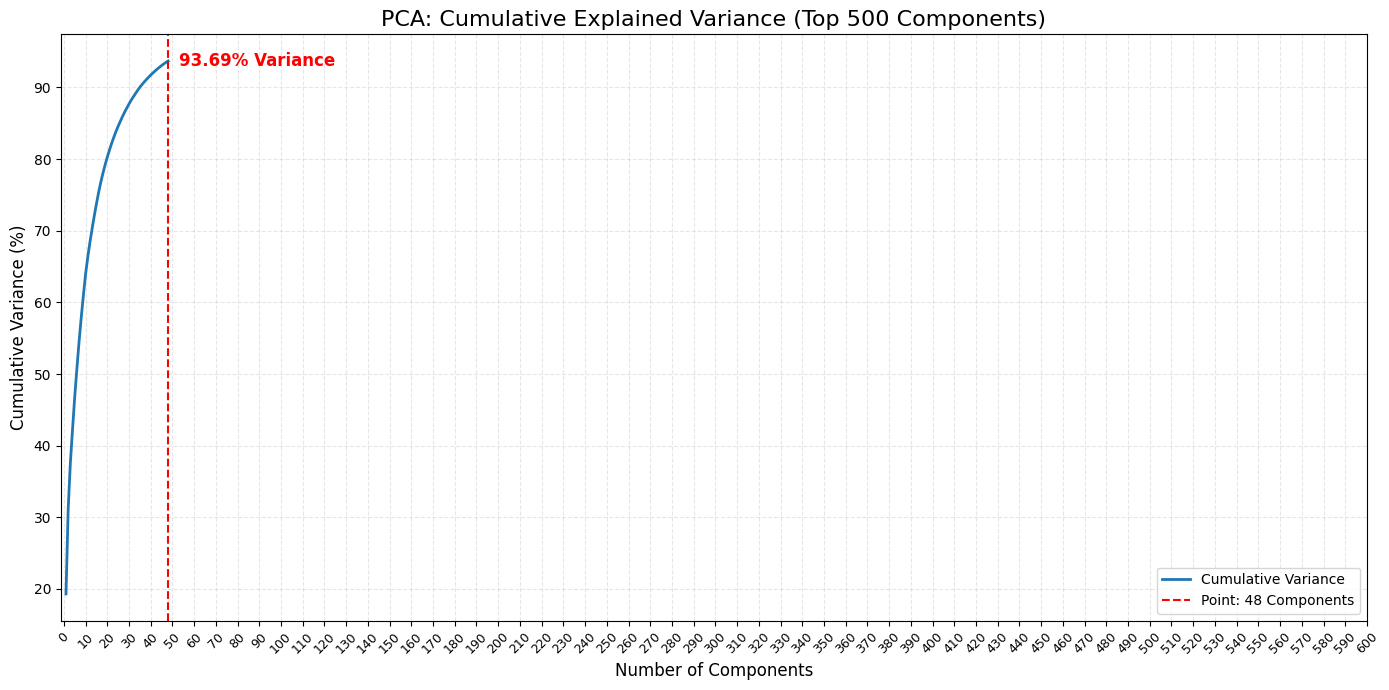

In [18]:
import matplotlib.pyplot as plt

# 1. Filter the data to the first 500 components
df_subset = df_variance

# 2. Extract the variance explained by exactly 48 components
# Since Python is 0-indexed, PC48 is at index 47
var_at_48 = df_subset.iloc[47]['Cumulative_Variance']

# 3. Set up the figure
plt.figure(figsize=(14, 7))

# 4. Plot the cumulative variance curve
plt.plot(range(1, len(df_subset) + 1), df_subset['Cumulative_Variance'], 
         color='tab:blue', linewidth=2, label='Cumulative Variance')

# 5. Add a vertical line at 48 components
plt.axvline(x=48, color='red', linestyle='--', linewidth=1.5, label='Point: 48 Components')

# 6. Add a text label showing the variance explained at n=48
# We offset the x position slightly (+5) so the text doesn't sit on the line
plt.text(48 + 5, var_at_48, f'{var_at_48:.2f}% Variance', 
         color='red', fontweight='bold', fontsize=12, verticalalignment='center')

# 7. Set x-axis ticks to show every 10th component for clarity
plt.xticks(range(0, 601, 10), rotation=45, fontsize=9)

# 8. Formatting labels and title
plt.title('PCA: Cumulative Explained Variance (Top 500 Components)', fontsize=16)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Variance (%)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.legend(loc='lower right')

# 9. Adjust layout and show
plt.tight_layout()
#plt.savefig('var_curve.png')
plt.show()

In [33]:
import pandas as pd

# 1. Generate 1,024 column names (embedding_1, embedding_2, ..., embedding_1024)
# We use i+1 so the count starts at 1 instead of 0
col_names = [f"embedding_{i+1}" for i in range(X_train.shape[1])]

# 2. Create the DataFrame
# usage of copy=False (optional) helps save memory by avoiding duplicating the large matrix
X_train = pd.DataFrame(X_train, columns=col_names, copy=False)

print(X_train.head())

   embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
0    -0.030746    -0.025558    -0.011536     0.048370     0.062988   
1    -0.035919    -0.019623    -0.011131     0.048340     0.059021   
2    -0.036133    -0.021408    -0.010719     0.052429     0.058777   
3    -0.036835    -0.019745    -0.010696     0.051147     0.062378   
4    -0.047333    -0.021057    -0.011436     0.057892     0.061401   

   embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  ...  \
0    -0.030655    -0.008934     0.049103    -0.026855      0.010353  ...   
1    -0.039673    -0.010117     0.042114    -0.030869      0.003166  ...   
2    -0.035645    -0.004166     0.042389    -0.023880      0.007030  ...   
3    -0.032745    -0.011353     0.048340    -0.034637      0.005932  ...   
4    -0.048859     0.008980     0.035614    -0.026108      0.006989  ...   

   embedding_55  embedding_56  embedding_57  embedding_58  embedding_59  \
0      0.022476      0.038696      0.033875    

/home/dkusmenko/.local/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


In [34]:
# 1. Generate 1,024 column names (embedding_1, embedding_2, ..., embedding_1024)
# We use i+1 so the count starts at 1 instead of 0
col_names = [f"embedding_{i+1}" for i in range(X_test.shape[1])]

# 2. Create the DataFrame
# usage of copy=False (optional) helps save memory by avoiding duplicating the large matrix
X_test = pd.DataFrame(X_test, columns=col_names, copy=False)


In [35]:
X_test

/home/dkusmenko/.local/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/dkusmenko/.local/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,...,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64
0,-0.037598,-0.022217,-0.010872,0.052643,0.064514,-0.033051,-0.010841,0.048187,-0.021561,0.003687,...,0.023148,0.041504,0.026825,-0.024216,0.041351,0.001825,-0.094299,0.077393,-0.080444,-0.066040
1,-0.033783,-0.021790,-0.011360,0.054077,0.056366,-0.035187,-0.006496,0.041229,-0.026428,0.007988,...,0.023315,0.034454,0.029007,-0.017426,0.041687,0.000144,-0.088135,0.073486,-0.077515,-0.066101
2,-0.034698,-0.016556,-0.011108,0.053864,0.066406,-0.042328,0.009834,0.031097,-0.035370,0.007694,...,0.024826,0.036896,0.032166,-0.035583,0.051971,0.002157,-0.080688,0.075256,-0.068665,-0.059448
3,-0.035553,-0.021561,-0.011223,0.052124,0.060211,-0.032043,-0.009010,0.041077,-0.027939,0.005577,...,0.024933,0.034882,0.032318,-0.017944,0.044159,0.003426,-0.087830,0.071289,-0.078674,-0.069092
4,-0.037292,-0.014000,-0.010643,0.054474,0.065430,-0.040436,0.010674,0.033600,-0.030930,0.011322,...,0.024643,0.033936,0.031586,-0.029968,0.046906,0.002426,-0.089661,0.074341,-0.066040,-0.063232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.037994,-0.016998,-0.011223,0.049347,0.057068,-0.050476,0.003813,0.034363,-0.025711,0.008110,...,0.030090,0.030975,0.028168,-0.041351,0.039581,0.000895,-0.084900,0.075623,-0.061890,-0.059387
9996,-0.040710,-0.017578,-0.011223,0.049469,0.065735,-0.031372,-0.011383,0.039429,-0.027939,0.004913,...,0.023743,0.035522,0.030777,-0.020187,0.043182,0.002472,-0.087402,0.076294,-0.075928,-0.061798
9997,-0.034241,-0.020325,-0.010864,0.047699,0.057983,-0.034088,-0.012802,0.042694,-0.027588,0.002861,...,0.026321,0.039795,0.033691,-0.015297,0.040436,0.003551,-0.088501,0.075867,-0.079102,-0.063965
9998,-0.036041,-0.019241,-0.010818,0.049316,0.058350,-0.034393,-0.011040,0.045868,-0.022461,0.005112,...,0.026733,0.032806,0.031082,-0.020508,0.039612,0.003016,-0.086121,0.070984,-0.077148,-0.067810


Processing Training Size: 200
Processing Training Size: 500
Processing Training Size: 1000
Processing Training Size: 2500
Processing Training Size: 5000
Processing Training Size: 7500
Processing Training Size: 10000
Processing Training Size: 15000
Processing Training Size: 20000
Processing Training Size: 25000
Processing Training Size: 35000
Processing Training Size: 40000


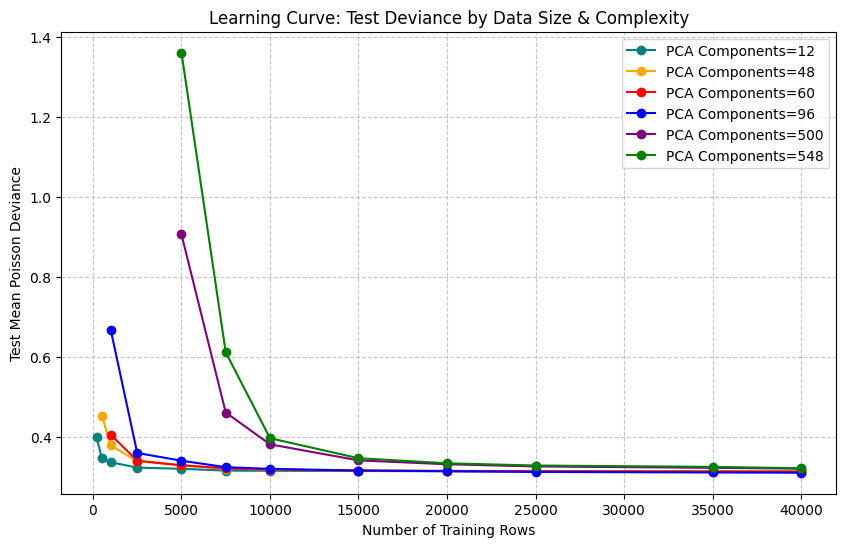

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm
import gc

# -------------------------------------------------------
# 1. Setup & Split
# -------------------------------------------------------
#X_train = train_df['X']
meta_train = [train_df['y'], train_df['w']]

meta_train = pd.DataFrame({
    'ClaimNb': meta_train[0],
    'Exposure': meta_train[1]
})

y_train = meta_train['ClaimNb']
offset_train = meta_train['Exposure']

#X_test = test_df['X']
meta_test = [test_df['y'], test_df['w']]

meta_test = pd.DataFrame({
    'ClaimNb': meta_test[0],
    'Exposure': meta_test[1]
})

y_test = meta_test['ClaimNb']
offset_test = meta_test['Exposure']


# -------------------------------------------------------
# 2. Configuration
# -------------------------------------------------------
# A. Define a comprehensive list of sizes (sorted)
#    Includes 200, 1000, and then jumps to 5000, 10000...
train_sizes = [200, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 35000, 40000]

# B. Define when each model is allowed to start
start_thresholds = {
    12: 200,
    48: 500,   # I set this to 200 as well, but you can change to 1000
    60: 1000,
    96: 1000,
    500: 5000,  # Strictly enforce 500 components starting at 5000 rows
    548: 5000
}

component_sets = [12, 48, 60, 96, 500, 548]
results_history = {k: [] for k in component_sets}



# -------------------------------------------------------
# 3. Learning Curve Loop
# -------------------------------------------------------
for size in train_sizes:
    print(f"Processing Training Size: {size}")
    
    # --- Slice Data ---
    X_train_sub = X_train.iloc[:size].copy()
    y_train_sub = y_train.iloc[:size]
    off_train_sub = offset_train.iloc[:size]
    
    # --- Scaling ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_sub)
    X_test_scaled = scaler.transform(X_test)

    del X_train_sub, scaler
    gc.collect()
    
    # --- PCA (Dynamic Fitting) ---
    # We cannot compute 500 components if we only have 200 rows.
    # We fit the maximum possible for this specific iteration.
    n_features = X_train_scaled.shape[1]
    max_k_possible = min(size, n_features, 548)
    
    pca = PCA(n_components=max_k_possible, random_state = 42)
    X_train_pca_all = pca.fit_transform(X_train_scaled)
    X_test_pca_all = pca.transform(X_test_scaled)

    del X_train_scaled, X_test_scaled, pca
    gc.collect()

    # --- Loop through component configurations ---
    for k in component_sets:
        
        # Check 1: User-defined Start Rule (e.g., Don't run 500 if size < 5000)
        if size < start_thresholds[k]:
            results_history[k].append(np.nan)
            continue

        # Check 2: Mathematical Rule (Can't extract 48 components from 12 features)
        if k > max_k_possible:
            results_history[k].append(np.nan)
            continue
            
        # Slice the required components
        X_train_k = X_train_pca_all[:, :k]
        X_test_k = X_test_pca_all[:, :k]
        
        # Fit GLM
        try:
            glm = sm.GLM(
                endog=y_train_sub, 
                exog=sm.add_constant(X_train_k), 
                offset=np.log(off_train_sub), 
                family=sm.families.Poisson()
            )
            res = glm.fit(disp=0)
            
            # Predict
            X_test_glm = sm.add_constant(X_test_k, has_constant='add')
            preds = res.predict(exog=X_test_glm, offset=np.log(offset_test))
            
            # Score
            mpd = mean_poisson_deviance(y_test, preds)
            results_history[k].append(mpd)
            
        except Exception as e:
            print(f"  Failed for k={k} at size={size}: {e}")
            results_history[k].append(np.nan)

        del X_train_k, X_test_k
        gc.collect()

# -------------------------------------------------------
# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

colors = {12: 'teal', 48: 'orange', 60: 'red', 96: 'blue', 500: 'purple', 548: 'green'}

for k in component_sets:
    # We filter out NaNs so the line connects properly for available data points
    # or keeps gaps where data is missing
    sizes_valid = [s for s, r in zip(train_sizes, results_history[k]) if not np.isnan(r)]
    scores_valid = [r for r in results_history[k] if not np.isnan(r)]
    
    plt.plot(sizes_valid, scores_valid, marker='o', linestyle='-', 
             color=colors.get(k, 'black'), label=f'PCA Components={k}')

plt.title('Learning Curve: Test Deviance by Data Size & Complexity')
plt.xlabel('Number of Training Rows')
#plt.xscale('log')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
#plt.savefig('lc_comp_pca_fix.png')
plt.show()

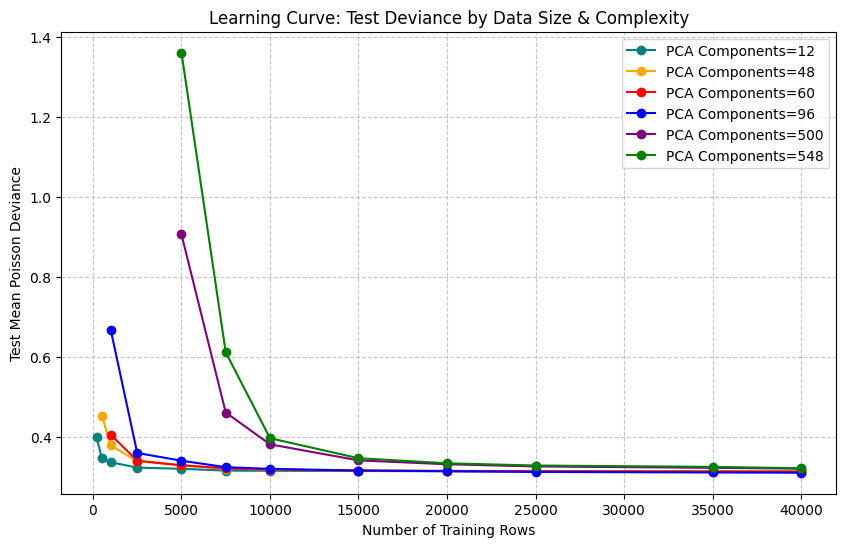

In [24]:
# -------------------------------------------------------
# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

colors = {12: 'teal', 48: 'orange', 60: 'red', 96: 'blue', 500: 'purple', 548: 'green'}

for k in component_sets:
    # We filter out NaNs so the line connects properly for available data points
    # or keeps gaps where data is missing
    sizes_valid = [s for s, r in zip(train_sizes, results_history[k]) if not np.isnan(r)]
    scores_valid = [r for r in results_history[k] if not np.isnan(r)]
    
    plt.plot(sizes_valid, scores_valid, marker='o', linestyle='-', 
             color=colors.get(k, 'black'), label=f'PCA Components={k}')

plt.title('Learning Curve: Test Deviance by Data Size & Complexity')
plt.xlabel('Number of Training Rows')
#plt.xscale('log')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
#plt.savefig('lc_comp_pca_fix.png')
plt.show()

In [25]:
for i in results_history.keys():
    print(results_history[i][-1])

0.31463539324557604
0.3144826922102383
0.31362165369147876
0.3111717584814175
0.32127543168540706
0.3222500815214755


## Learning Curves

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


X_train = train_df['X']
meta_train = [train_df['y'], train_df['w']]

meta_train = pd.DataFrame({
    'ClaimNb': meta_train[0],
    'Exposure': meta_train[1]
})


X_test = test_df['X']
meta_test = [test_df['y'], test_df['w']]

meta_test = pd.DataFrame({
    'ClaimNb': meta_test[0],
    'Exposure': meta_test[1]
})

# 3. Setup Scaler & PCA with Pandas Output
# ---------------------------------------------------------
# This tiny change saves you lines of code:
scaler = StandardScaler().set_output(transform='pandas')
pca = PCA(n_components=48).set_output(transform='pandas')

# 4. Pipeline Execution
# ---------------------------------------------------------
# TRAIN: Fit & Transform
# Scaler returns a DF with index preserved -> PCA returns a DF with index preserved
X_train_scaled = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)

# TEST: Transform Only
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

# 5. Fast Reconstruction
# ---------------------------------------------------------
# Because indices are preserved, pandas aligns rows automatically.
# We can also rename columns cleanly if we want "PC1" instead of "pca0"

# Optional: Rename columns from 'pca0' to 'PC1', 'PC2'...
new_col_names = [f"PC{i+1}" for i in range(48)]
X_train_pca.columns = new_col_names
X_test_pca.columns = new_col_names

# Concatenate (Join)
final_train = pd.concat([X_train_pca, meta_train], axis=1)
final_test = pd.concat([X_test_pca, meta_test], axis=1)

print(f"Original Predictors: {len(X_train)}")
print(f"Reduced Predictors:  {X_train_pca.shape[1]}")
print(f"Final Train Shape:   {final_train.shape}")
print(final_train.head())

Original Predictors: 80000
Reduced Predictors:  48
Final Train Shape:   (80000, 50)
        PC1        PC2       PC3        PC4       PC5        PC6       PC7  \
0  2.590744 -11.607974 -9.453911  -2.555164  5.547899  -1.801319  1.612984   
1  5.140200  14.029841 -6.578761 -14.832194  3.817817  14.537741  4.967456   
2  3.265676 -10.716380 -0.399935   5.027586  1.488902  -2.673960 -0.574567   
3  1.677195  25.037846 -2.266536  -7.688927  0.381395   7.184455  8.436134   
4  4.563725  -4.789312  8.385945  -1.758243  0.402021   2.391398  1.203986   

        PC8        PC9       PC10  ...      PC41      PC42      PC43  \
0  0.206200   3.910362   1.557287  ...  0.273654 -0.502503  1.692318   
1 -3.030988  -4.599479   3.399025  ... -2.422759 -0.564113 -0.036389   
2  6.446812 -11.555267   4.450533  ...  1.448662 -2.900756 -0.761787   
3  3.248297   6.623673 -15.250688  ...  2.583694  0.224377  0.141001   
4  6.932502   4.053981   8.121994  ...  2.861421  0.413908 -2.347723   

       PC44   

Size 500: 0.71766
Size 878: 0.47381
Size 1544: 0.33916
Size 2714: 0.32487
Size 4770: 0.31311
Size 8384: 0.31110
Size 14736: 0.30738
Size 25899: 0.30568
Size 45518: 0.30443
Size 80000: 0.30421


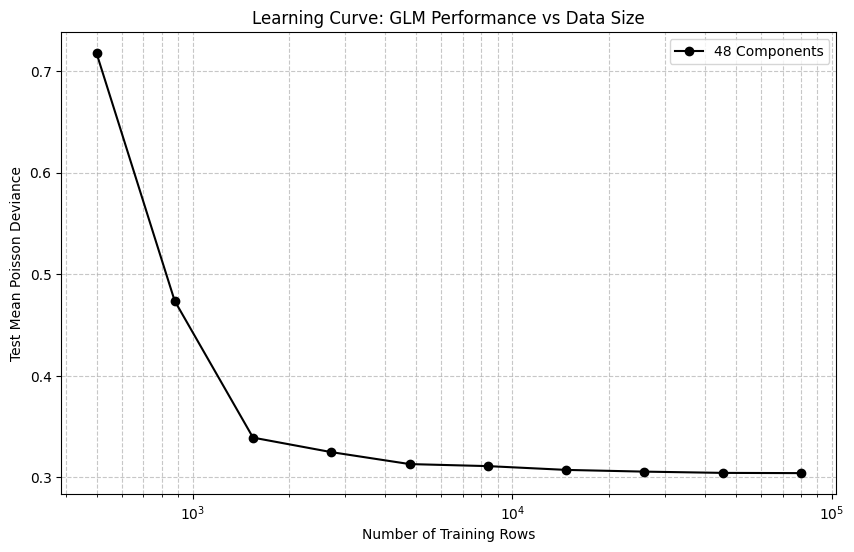

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_poisson_deviance
import statsmodels.api as sm



# -------------------------------------------------------
# 1. Setup & Split
# -------------------------------------------------------
X_train = X_train_pca
meta_train = [train_df['y'], train_df['w']]

meta_train = pd.DataFrame({
    'ClaimNb': meta_train[0],
    'Exposure': meta_train[1]
})

y_train = meta_train['ClaimNb']
offset_train = meta_train['Exposure']

X_test = X_test_pca
meta_test = [test_df['y'], test_df['w']]

meta_test = pd.DataFrame({
    'ClaimNb': meta_test[0],
    'Exposure': meta_test[1]
})

y_test = meta_test['ClaimNb']
offset_test = meta_test['Exposure']


# Pre-add constant to Test set (since it never changes)
X_test_glm = sm.add_constant(X_test, has_constant='add')

# 3. Learning Curve Loop
# -------------------------------------------------------
train_sizesr = np.geomspace(500, 80000, num=10, dtype=int)
deviancesr_2 = []

for size in train_sizesr:
    # A. Slice the first 'size' rows from the ALREADY TRANSFORMED data
    # We use .iloc because X_train_pca_all is a dataframe
    X_train_sub = X_train.iloc[:size]
    y_train_sub = y_train.iloc[:size]
    off_train_sub = offset_train.iloc[:size]
    
    # B. Add constant for Statsmodels
    X_train_glm = sm.add_constant(X_train_sub)
    
    # C. Fit GLM
    glm = sm.GLM(
        endog=y_train_sub, 
        exog=X_train_glm, 
        offset=np.log(off_train_sub), 
        family=sm.families.Poisson()
    )
    results = glm.fit()
    
    # D. Predict on fixed Test Set
    preds = results.predict(exog=X_test_glm, offset=np.log(offset_test))
    
    # E. Score
    mpd = mean_poisson_deviance(y_test, preds)
    deviancesr_2.append(mpd)
    print(f"Size {size}: {mpd:.5f}")
    

# 4. Plotting
# -------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(train_sizesr, deviancesr_2, marker='o', linestyle='-', color='black', label=f'48 Components')
plt.xscale('log')
plt.title('Learning Curve: GLM Performance vs Data Size')
plt.xlabel('Number of Training Rows')
plt.ylabel('Test Mean Poisson Deviance')
plt.grid(True, linestyle='--', alpha=0.7, which = 'both')
plt.legend()

#plt.savefig('pca_learning_curve3.png')
plt.show()

Textbook beating fine tuned GLM at 48 embeddings, embeddings better at 60 and 96. 48 components does start out much lower than raw data, and appears to be decreasing at a greater rate approaching 40k rows of data (jump of 0.00115 vs 0.00078), so likely has more room for improvement with more data